## More from arch

_This setup code is required to run in an IPython notebook_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [3]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_open, pct_high, pct_low, pct_close from USEQ_HIST where symbol="MS"
    and volume>0
     order by tradedate''',
    conn,
    index_col='tradedate'
)
df = pd.DataFrame(SQL_query, columns=["pct_open","pct_high","pct_low","pct_close"])

df.head()

,pct_open,pct_high,pct_low,pct_close
tradedate,,,,
2016-01-04,-3.48946,-0.911660,-3.92958,-1.03741
2016-01-05,2.54071,0.571067,1.21074,-0.63532
2016-01-06,-2.70013,-2.902210,-2.19851,-2.49361
2016-01-07,-2.44858,-2.306700,-4.85950,-4.98361
2016-01-08,-1.57296,-1.928830,-1.66783,-2.07039


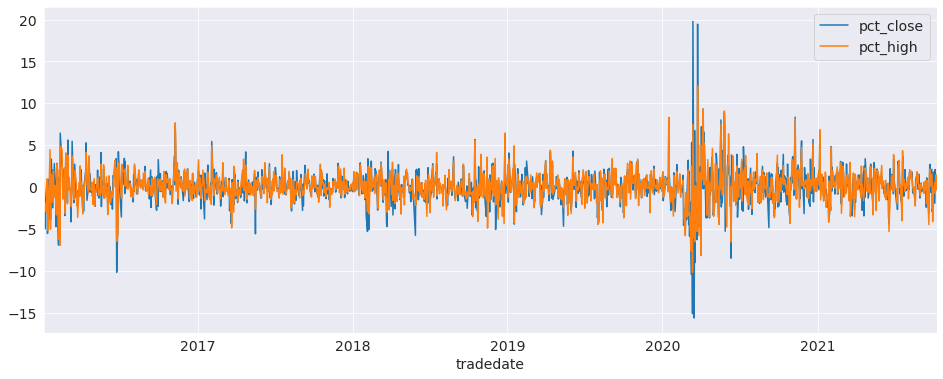

In [4]:
ax = plt.gca()
df.plot(y='pct_close', ax=ax)
df.plot(y='pct_high', ax=ax)
xlim = ax.set_xlim(df.index.min(), df.index.max())

In [5]:
from arch import arch_model

## GJR-Garch with Student's T

In [6]:
am = arch_model(df["pct_close"], p=1, o=1, q=1, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 2835.8060228482536
Iteration:     10,   Func. Count:     92,   Neg. LLF: 2831.558186063096
Iteration:     15,   Func. Count:    135,   Neg. LLF: 2830.9977625383067
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2830.99718194925
            Iterations: 19
            Function evaluations: 167
            Gradient evaluations: 19
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2831.00
Distribution:      Standardized Student's t   AIC:                           5673.99
Method:                  Maximum Likelihood   BIC:                           5705.67
                                              No. Observations

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.


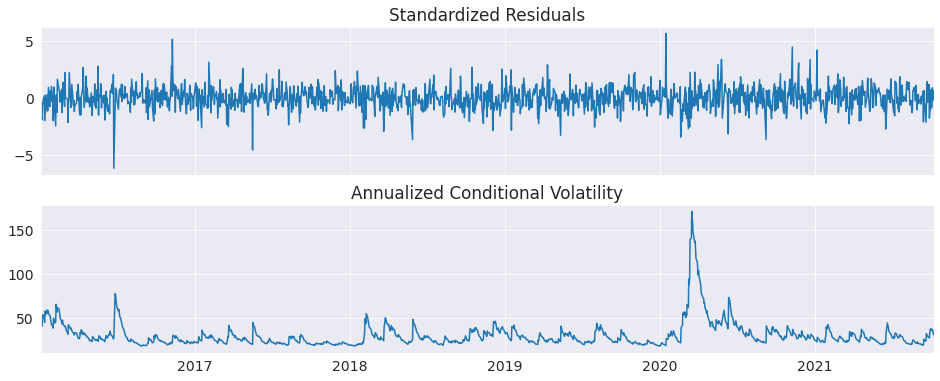

In [7]:
fig = res.plot(annualize="D")

## Parameters


In [8]:
res.params

mu          0.078935
omega       0.158157
alpha[1]    0.033326
gamma[1]    0.169173
beta[1]     0.846277
nu          5.591634
Name: params, dtype: float64

## Forecasts

In [9]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=10, reindex=False)
print(forecasts.residual_variance.iloc[-3:])


                 h.1
tradedate           
2021-10-08  0.078935
                h.01      h.02      h.03      h.04      h.05      h.06  \
tradedate                                                                
2021-10-08  3.328691  3.367645  3.405204  3.441418  3.476335  3.510002   

                h.07      h.08      h.09      h.10  
tradedate                                           
2021-10-08  3.542463  3.573761  3.603939  3.633036  


In [10]:
conn.close()